# 1. Gerekli Kütüphaneler

In [52]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [53]:
!pip install -q efficientnet_pytorch

In [54]:
from efficientnet_pytorch import EfficientNet

# 2. Veriyi Hazırlama
#### Burada her bir klasörde hangi sınıfta kaç örnek var ona bakıldı. 

In [55]:
DATA_DIR = '/kaggle/input/data'
LABEL_CSV = os.path.join(DATA_DIR, 'Data_Entry_2017.csv')

# Etiket dosyasını oku
df = pd.read_csv(LABEL_CSV)
df['Finding Labels'] = df['Finding Labels'].str.split('|').str[0]  # sadece ilk hastalık

# images_XXX klasörlerini bul
image_folders = [f for f in os.listdir(DATA_DIR) if f.startswith('images_')]

result = {}

for folder in image_folders:
    images_subdir = os.path.join(DATA_DIR, folder, "images")
    if not os.path.isdir(images_subdir):
        continue
    files_in_folder = set(os.listdir(images_subdir))
    df_folder = df[df['Image Index'].isin(files_in_folder)]
    class_counts = df_folder['Finding Labels'].value_counts()
    result[folder] = class_counts

# Sonuçları yazdır
for folder, counts in result.items():
    print(f"\nKlasör: {folder}/images")
    print(counts)


Klasör: images_003/images
Finding Labels
No Finding            5844
Atelectasis            920
Infiltration           839
Effusion               568
Cardiomegaly           376
Nodule                 315
Consolidation          273
Mass                   230
Fibrosis               128
Pneumothorax           128
Emphysema              122
Edema                  118
Pleural_Thickening     106
Pneumonia               21
Hernia                  12
Name: count, dtype: int64

Klasör: images_012/images
Finding Labels
No Finding            3641
Infiltration           835
Atelectasis            745
Effusion               584
Pneumothorax           208
Consolidation          207
Nodule                 195
Cardiomegaly           187
Mass                   175
Emphysema              161
Edema                   72
Pleural_Thickening      62
Fibrosis                26
Hernia                  12
Pneumonia               11
Name: count, dtype: int64

Klasör: images_009/images
Finding Labels
No Finding  

#### Burada veri setinin tümünde sınıf başına örnek sayısı kontrol edildi

In [56]:
import pandas as pd
DATA_DIR = '/kaggle/input/data'
df = pd.read_csv(f"{DATA_DIR}/Data_Entry_2017.csv")

from collections import Counter

all_labels = df['Finding Labels'].str.split('|').explode()
class_counts = all_labels.value_counts()
print(class_counts)

Finding Labels
No Finding            60361
Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
Name: count, dtype: int64


#### Her sınıftan 500 örnek alındı, 500'ün altında örnek olanlara oversampling yapıldı

In [57]:
# --- SINIF BAŞINA İSTENEN SAYIDA ÖRNEK AL ---
from sklearn.utils import resample

# Tüm images klasörlerinin altındaki dosyaları topla
image_folders = [f for f in os.listdir(DATA_DIR) if f.startswith('images_')]
all_files = []
for folder in image_folders:
    images_subdir = os.path.join(DATA_DIR, folder, "images")
    if os.path.isdir(images_subdir):
        image_files = os.listdir(images_subdir)
        for fname in image_files:
            all_files.append((fname, f"{folder}/images/{fname}")) 

In [58]:
# DataFrame'e tam yolunu ekle
df = df[df['Image Index'].isin([f[0] for f in all_files])].reset_index(drop=True)
filename2fullpath = dict(all_files)
df['rel_path'] = df['Image Index'].map(filename2fullpath)

In [59]:
# SINIF BAŞINA İSTENEN SAYIDA ÖRNEK AL
class_counts = {
    "No Finding": 2000,
    "Infiltration": 2000,
    "Effusion": 1500,
    "Atelectasis": 1600,
    "Nodule": 1400,
    "Mass": 1400,
    "Pneumothorax": 1400,
    "Consolidation": 1200,
    "Pleural_Thickening": 2000,
    "Cardiomegaly": 1000,
    "Emphysema": 1000,
    "Edema": 1200,
    "Fibrosis": 1200,
    "Pneumonia": 1000,
    "Hernia": 3400
}

sampled_df = pd.concat([
    df[df['Finding Labels'] == label].sample(n=count, replace=True, random_state=42)
    for label, count in class_counts.items()
]).reset_index(drop=True)


In [60]:
# Her sınıfın örnek sayısı
print(sampled_df['Finding Labels'].value_counts())

Finding Labels
Hernia                3400
Infiltration          2000
No Finding            2000
Pleural_Thickening    2000
Atelectasis           1600
Effusion              1500
Nodule                1400
Pneumothorax          1400
Mass                  1400
Edema                 1200
Consolidation         1200
Fibrosis              1200
Cardiomegaly          1000
Emphysema             1000
Pneumonia             1000
Name: count, dtype: int64


In [61]:
total_samples = sampled_df['Finding Labels'].value_counts().sum()
print("Toplam örnek sayısı:", total_samples)

Toplam örnek sayısı: 23300


In [62]:
# Kaydet CSV olarak, yol ve etiket ile
sampled_df[['rel_path', 'Finding Labels']].to_csv('nih_chestxray_sampled_df0.csv', index=False)
print("Hazır veri seti 'nih_chestxray_sampled_df0.csv' olarak kaydedildi.")

Hazır veri seti 'nih_chestxray_sampled_df0.csv' olarak kaydedildi.


In [63]:
# =================== CONFIG ======================
DATA_DIR = '/kaggle/input/data'
CSV_PATH = '/kaggle/working/nih_chestxray_sampled_df0.csv'
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 10

# =================================================

In [64]:
# 1. Balanced dataframe'i oku
df = pd.read_csv(CSV_PATH)

In [65]:
# 2. Etiketleri encode et
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label_idx'] = le.fit_transform(df['Finding Labels'])

In [66]:
# 3. Train/val split (stratify!)
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label_idx'],
    random_state=42
)

# 3. PyTorch Dataset

In [67]:
# --- DATASET CLASS'INDA TRANSFORMLARI AYRI AL, HERNIA'YA ÖZEL AUGMENTATION ---
from torch.utils.data import Dataset
from PIL import Image
import os

class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, img_dir, base_transform=None, hernia_transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.base_transform = base_transform  # DİĞER SINIFLAR İÇİN
        self.hernia_transform = hernia_transform  # SADECE HERNIA İÇİN

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_relative_path = self.dataframe.iloc[idx]['rel_path']
        label_idx = self.dataframe.iloc[idx]['label_idx']
        label_name = self.dataframe.iloc[idx]['Finding Labels']  # veya 'label' sütunu

        img_path = os.path.join(self.img_dir, img_relative_path)
        image = Image.open(img_path).convert("RGB")

        # HERNIA İÇİN SADECE AUGMENTATION UYGULA, DİĞERLERİNE BASE TRANSFORM
        if label_name == "Hernia":
            if self.hernia_transform:
                image = self.hernia_transform(image)
        else:
            if self.base_transform:
                image = self.base_transform(image)

        return image, label_idx


# 4. Transformlar ve DataLoaderlar

In [68]:
# 4. Transformlar ve DataLoaderlar
from torchvision import transforms
from torch.utils.data import DataLoader

base_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

hernia_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),   # DAHA AĞIR AUGMENTATION
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.10, 0.10), scale=(0.90, 1.10)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [69]:
# DATASET OLUŞTURURKEN BASE VE HERNIA TRANSFORM İLE VER! ---
train_dataset = ChestXrayDataset(train_df, DATA_DIR, base_transform=base_transform, hernia_transform=hernia_transform)
val_dataset = ChestXrayDataset(val_df, DATA_DIR, base_transform=val_transform, hernia_transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# 5. Model

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_classes = df['label_idx'].nunique()

model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=n_classes)
model = model.to(device)

Loaded pretrained weights for efficientnet-b0


In [71]:
# TÜM KATLARI DONDUR (FROZEN)
for param in model.parameters():
    param.requires_grad = False

# SADECE SON KATMANI (classifier) EĞİTİLEBİLİR YAP
for param in model._fc.parameters():  # EfficientNet'te son katman _fc
    param.requires_grad = True

# 6. Kayıp ve Optimizasyon

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)  # verbose parametresi kaldırıldı


# 7. Eğitim Döngüsü


In [73]:
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total_train = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_correct / total_train
    print(f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * images.size(0)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
    scheduler.step(val_loss)
    # GÜNCEL ÖĞRENME ORANIYLA İLGİLİ LOG EKLE
    print(f"Current LR: {optimizer.param_groups[0]['lr']}")

Epoch 1/10: 100%|██████████| 583/583 [03:56<00:00,  2.46it/s]

Train Loss: 2.2216 | Train Accuracy: 0.2696


Validation Loss: 2.7126 | Validation Accuracy: 0.1567
Current LR: 0.001


Epoch 2/10: 100%|██████████| 583/583 [04:01<00:00,  2.42it/s]

Train Loss: 2.0430 | Train Accuracy: 0.3245


Validation Loss: 2.8081 | Validation Accuracy: 0.1951
Current LR: 0.001


Epoch 3/10: 100%|██████████| 583/583 [04:03<00:00,  2.40it/s]

Train Loss: 1.9857 | Train Accuracy: 0.3467


Validation Loss: 2.7308 | Validation Accuracy: 0.2185
Current LR: 0.001


Epoch 4/10: 100%|██████████| 583/583 [04:00<00:00,  2.42it/s]

Train Loss: 1.9478 | Train Accuracy: 0.3587


Validation Loss: 2.7615 | Validation Accuracy: 0.2273
Current LR: 0.0005


Epoch 5/10: 100%|██████████| 583/583 [04:01<00:00,  2.41it/s]

Train Loss: 1.9058 | Train Accuracy: 0.3738


Validation Loss: 2.7259 | Validation Accuracy: 0.2354
Current LR: 0.0005


Epoch 6/10: 100%|██████████| 583/583 [03:53<00:00,  2.50it/s]

Train Loss: 1.8835 | Train Accuracy: 0.3838


Validation Loss: 2.7635 | Validation Accuracy: 0.2429
Current LR: 0.0005


Epoch 7/10: 100%|██████████| 583/583 [03:57<00:00,  2.45it/s]

Train Loss: 1.8853 | Train Accuracy: 0.3810


Validation Loss: 2.7239 | Validation Accuracy: 0.2448
Current LR: 0.00025


Epoch 8/10: 100%|██████████| 583/583 [03:55<00:00,  2.47it/s]

Train Loss: 1.8632 | Train Accuracy: 0.3935


Validation Loss: 2.7765 | Validation Accuracy: 0.2408
Current LR: 0.00025


Epoch 9/10: 100%|██████████| 583/583 [03:58<00:00,  2.45it/s]

Train Loss: 1.8591 | Train Accuracy: 0.3918


Validation Loss: 2.7504 | Validation Accuracy: 0.2391
Current LR: 0.00025


Epoch 10/10: 100%|██████████| 583/583 [03:58<00:00,  2.44it/s]

Train Loss: 1.8591 | Train Accuracy: 0.3927


Validation Loss: 2.7894 | Validation Accuracy: 0.2451
Current LR: 0.000125


## FINE-TUNING (TÜM KATLAR AÇIK)

In [74]:
NUM_EPOCHS_FROZEN = 7
NUM_EPOCHS_FINETUNE = 10

In [75]:
print("\n=== FINE-TUNING: TÜM KATLAR EĞİTİLİYOR ===")

# MODELİN TÜM KATLARINI EĞİTİLEBİLİR YAP
for param in model.parameters():
    param.requires_grad = True

# OPTİMİZERİ TÜM PARAMETRELER İÇİN YENİDEN OLUŞTUR, DAHA DÜŞÜK LR
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)


=== FINE-TUNING: TÜM KATLAR EĞİTİLİYOR ===


In [76]:
for epoch in range(NUM_EPOCHS_FINETUNE):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total_train = 0
    print(f"Current LR: {optimizer.param_groups[0]['lr']}")
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS_FINETUNE} (Finetune)"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_correct / total_train
    print(f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * images.size(0)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
    scheduler.step(val_loss)
    print(f"Current LR: {optimizer.param_groups[0]['lr']}")

Current LR: 0.0001


Epoch 1/10 (Finetune): 100%|██████████| 583/583 [04:15<00:00,  2.28it/s]

Train Loss: 1.7383 | Train Accuracy: 0.4352


Validation Loss: 2.6653 | Validation Accuracy: 0.3461
Current LR: 0.0001
Current LR: 0.0001


Epoch 2/10 (Finetune): 100%|██████████| 583/583 [04:14<00:00,  2.29it/s]

Train Loss: 1.3885 | Train Accuracy: 0.5594


Validation Loss: 2.3718 | Validation Accuracy: 0.4170
Current LR: 0.0001
Current LR: 0.0001


Epoch 3/10 (Finetune): 100%|██████████| 583/583 [04:16<00:00,  2.28it/s]

Train Loss: 1.1022 | Train Accuracy: 0.6627


Validation Loss: 2.5348 | Validation Accuracy: 0.4470
Current LR: 0.0001
Current LR: 0.0001


Epoch 4/10 (Finetune): 100%|██████████| 583/583 [04:17<00:00,  2.27it/s]

Train Loss: 0.8625 | Train Accuracy: 0.7376


Validation Loss: 2.4920 | Validation Accuracy: 0.4856
Current LR: 0.0001
Current LR: 0.0001


Epoch 5/10 (Finetune): 100%|██████████| 583/583 [04:13<00:00,  2.30it/s]

Train Loss: 0.6556 | Train Accuracy: 0.8022


Validation Loss: 2.5915 | Validation Accuracy: 0.5090
Current LR: 5e-05
Current LR: 5e-05


Epoch 6/10 (Finetune): 100%|██████████| 583/583 [04:09<00:00,  2.34it/s]

Train Loss: 0.4563 | Train Accuracy: 0.8716


Validation Loss: 2.6375 | Validation Accuracy: 0.5281
Current LR: 5e-05
Current LR: 5e-05


Epoch 7/10 (Finetune): 100%|██████████| 583/583 [04:12<00:00,  2.31it/s]

Train Loss: 0.3646 | Train Accuracy: 0.9005


Validation Loss: 2.6759 | Validation Accuracy: 0.5232
Current LR: 5e-05
Current LR: 5e-05


Epoch 8/10 (Finetune): 100%|██████████| 583/583 [04:05<00:00,  2.37it/s]

Train Loss: 0.3148 | Train Accuracy: 0.9138


Validation Loss: 2.8438 | Validation Accuracy: 0.5273
Current LR: 2.5e-05
Current LR: 2.5e-05


Epoch 9/10 (Finetune): 100%|██████████| 583/583 [04:06<00:00,  2.37it/s]

Train Loss: 0.2518 | Train Accuracy: 0.9351


Validation Loss: 2.8045 | Validation Accuracy: 0.5273
Current LR: 2.5e-05
Current LR: 2.5e-05


Epoch 10/10 (Finetune): 100%|██████████| 583/583 [04:01<00:00,  2.42it/s]

Train Loss: 0.2235 | Train Accuracy: 0.9416


Validation Loss: 3.0066 | Validation Accuracy: 0.5279
Current LR: 2.5e-05


## **Confusion Matrix**

In [80]:
from sklearn.metrics import confusion_matrix

# BÜTÜN VALİDASYON VERİSİNDE TAHMİN YAP
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

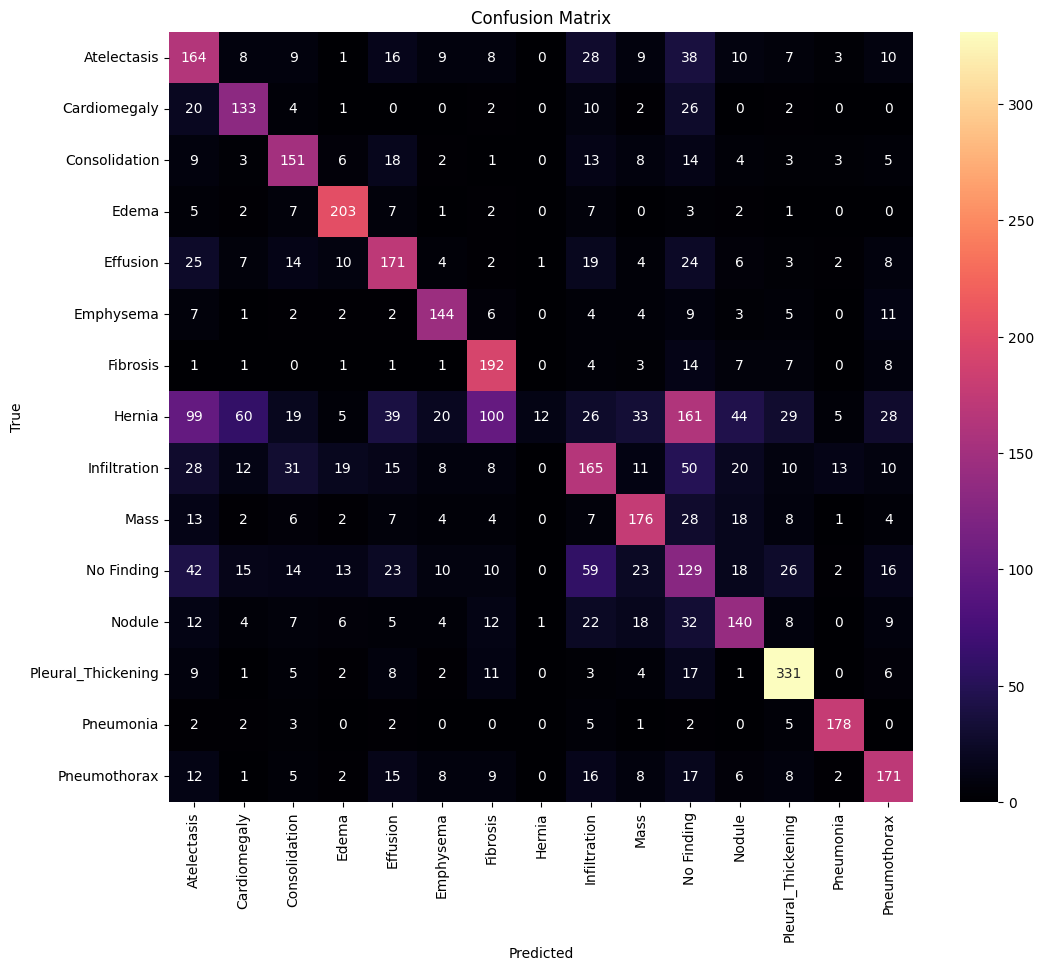

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sınıf isimlerin varsa (örneğin, le.classes_ ile alabilirsin)
class_names = le.classes_  # LabelEncoder ile encode ettiysen

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("grafik.png")
plt.show()

# 8. Modeli Kaydet

In [ ]:
MODEL_PATH = './efficientnet_b0_nih_chestxray_val07834.pth'
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model kaydedildi: {MODEL_PATH}")